---
title: 9.7 Transformer
date: 2024-7-9 12:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#  
<!--more-->
# 7 Transformer

- 自注意力同时具有并行计算和最短和最大路径长度这两个优势。

- 对比之前仍然依赖rnn实现输入表示的自注意力模型，Transformer完全基于注意力机制，没有任何卷积层或rnn层。

## 7.1 模型

- 编码器-解码器架构。
![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/9_attention/7_transformer/1.jpg)
![](img/deeplearning/code/pytorch/9_attention/7_transformer/1.jpg)

    - 编码器由多个层叠加，每个层有两个子层（sublayer）
        - 第一个子层是multi-head self-attention汇聚；
        - 第二个子层是基于位置的前馈网络（positionwise feed-forward network）
        - 在计算编码器的注意力时，q,k,v都来自前一个编码器层的输出。输入序列对应的每个位置，Transformer编码器都将输出一个d维表示向量

    - 解码器多了一个子层：encoder-decoder attention层。其中q来自前一个解码器层的输出，但k,v来自整个编码器的输出。
    - 在解码器注意力中，q,k,v都来自撒谎给你一个解码器层的输出。但是解码器中的每一个位置只能考虑该位置之前的所有位置。这种masked attention保留了自回归（auto-regressive）属性，确保预测仅依赖于已生成的输出词元。

In [63]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 7.2 基于位置的前馈网络

- 基于位置的前馈网络对序列中所有位置的表示进行变换时 使用的是同一个mlp，因此称前馈网络是基于位置的。
- (batch, n, hidden) -> (batch, n, output)

In [64]:
#@save
class PositionWiseFFN(nn.Module):
    '''基于位置的前馈网络'''
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))



- 因为使用同一个多层感知机对所有位置上的输入进行变换，所以当这些位置的输入相同时，输出相同：
    - 输入3个序列，特征长度4；由于输入的三个序列一样，所以输出的三个序列也一样。

In [65]:
ffn = PositionWiseFFN(4,4,8)
ffn.eval()
ffn(torch.ones((2,3,4)))[0]

tensor([[-0.1351,  0.5875,  1.0552, -0.2889, -1.1500, -1.1897, -0.7666,  0.4518],
        [-0.1351,  0.5875,  1.0552, -0.2889, -1.1500, -1.1897, -0.7666,  0.4518],
        [-0.1351,  0.5875,  1.0552, -0.2889, -1.1500, -1.1897, -0.7666,  0.4518]],
       grad_fn=<SelectBackward0>)

## 7.3 残差连接和层规范化

- 层规范化和批量规范化目标相同
    - 层规范化：基于特征维度进行规范化
- 尽管批量规范化在cv中广泛应用，但nlp中（输入通常是变长序列）层规范化更好。

- 对比不同维度的层规范化和批量规范化的效果：(一个横着归一化，一个竖着归一化)

In [66]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1,2],[2,3]], dtype=torch.float32)
# 训练模式下计算X的均值和方差
print('layer norm:',ln(X), '\nbatch norm:',bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


- 使用残差连接和层规范化：

In [67]:
#@save
class AddNorm(nn.Module):
    '''残差连接后进行层规范化'''
    def __init__(self, normalized_shape, dropout, **kwargs) -> None: #不用输入batch维度
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)
    
add_norm = AddNorm([3,4], 0.5)
add_norm.eval()
add_norm(torch.ones((2,3,4)), torch.ones((2,3,4))).shape

torch.Size([2, 3, 4])

## 7.4 编码器

In [68]:
#@save
class EncoderBlock(nn.Module):
    '''transformer编码器块'''
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias
        )
        self.addnorm1 = AddNorm(norm_shape, dropout)

        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X,self.attention(X,X,X,valid_lens))
        return self.addnorm2(Y,self.ffn(Y))

- Transformer编码器不会改变输入的形状

In [69]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3,2])
encoder_blk = EncoderBlock(24,24,24,24,[100,24],24,48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

- Transformer编码器：堆叠了多个EncoderBlock

    - 由于使用的[-1,1]的固定位置编码，因此通过学习得到的input的嵌入表示需要先乘以embedding dim的平方根进行重新缩放，然后与位置编码相加？？？

In [70]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                'block' + str(i), EncoderBlock(
                    key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,dropout, use_bias
                )
                )
    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens)) #sqrt???
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

- 创建一个两层的Transformer编码器，输出形状（批大小，时间步数目，num_hiddens）。

In [71]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2,100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## 7.5 解码器
- 三个子层：

    - 解码器self attention

    - 编码器-解码器attention

    - 基于位置的前馈网络

- seq to seq模型中，在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的self attention计算中。为了在解码器中保留自回归属性，其掩蔽自注意力设定了参数dec_valid_lens，以便任何查询都只会与解码器中所有已经生成词元的位置进行注意力计算。

In [72]:
class DecoderBlock(nn.Module):
    '''解码器中第i个块'''
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)

        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None: #训练时，输出序列的所有词元同时处理，因此state[2][self.i]初始化为none
            key_values = X
        else: #预测阶段，输出序列是通过词元一个接一个解码的，因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
            key_values = torch.cat((state[2][self.i],X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps+1, device=X.device).repeat(batch_size, 1) #dec_valid_lens的开头：（batch size, num steps)，其中每一行是[1,2,...,num steps]
        else:
            dec_valid_lens = None
        
        #self attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        #encoder-decoder attention
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

- 为了便于在encoder-decoder attention中进行缩放点积计算和残差连接中进行加法计算，encoder和decoder的特征维度都是num hiddens

In [73]:
decoder_blk = DecoderBlock(24,24,24,24,[100,24],24,48,8,0.5,0)
decoder_blk.eval()
X = torch.ones((2,100,24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

- Transformer解码器

In [74]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,
                                              ffn_num_input, ffn_num_hiddens, num_heads, dropout, i)
                                 )
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(slef, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None]*slef.num_layers]
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器self attention权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # encoder-decoder self attention权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    @property
    def attention_weights(self):
        return self._attention_weights

## 7.6 训练

loss 0.031, 7034.3 tokens/sec on cpu


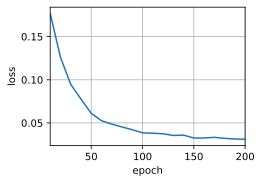

In [75]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = TransformerEncoder(
                            len(src_vocab), key_size, query_size, value_size, num_hiddens,
                            norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                            num_layers, dropout)
decoder = TransformerDecoder(
                            len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
                            norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                            num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

- 测试翻译，计算BLEU分数

In [76]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',f'bleu {d2l.bleu(translation, fra, k=2):.3f}')


go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


- 可视化Transformer的注意力权重，编码器自注意力权重为（编码器层数，注意力头数，num_steps或查询的数目，num_steps或键值对的数目）

In [83]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers,num_heads,-1,num_steps))
print(len(net.encoder.attention_weights))
print(net.encoder.attention_weights[0].shape)
enc_attention_weights.shape

2
torch.Size([4, 10, 10])


torch.Size([2, 4, 10, 10])

- 在编码器self attention中，q，k都来自相同的输入序列。因为填充词元是不携带信息的，因此通过指定输入序列的有效长度可以避免q与使用填充词元的位置计算注意力。

- 逐行呈现两层4头注意力的权重。每个注意力头根据q,k,v的不同表示子空间来表示不同的注意力。

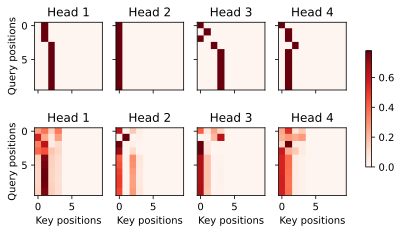

In [84]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],figsize=(7, 3.5))


- 为了可视化解码器注意力权重，需要完成更多数据操作工作。如用0填充被掩蔽的注意力权重。值得注意的是，解码器的注意力权重和encoder-decoder注意力权重都有相同的查询：即以序列开始词元（BOS）开头，再与后续输出的词元共同组成序列。

In [85]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape


(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

- 由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算。

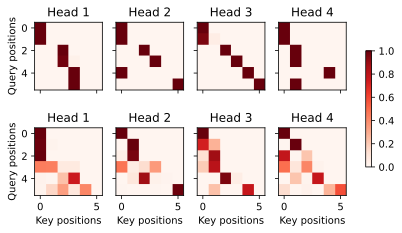

In [86]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

- 与编码器的自注意力的情况类似，通过指定输入序列的有效长度，输出序列的查询不会与输入序列中填充位置的词元进行注意力计算。

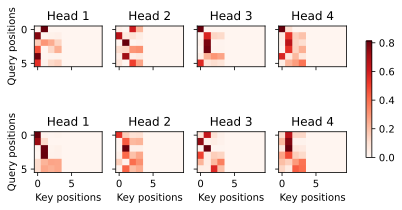

In [87]:
d2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key positions',ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],figsize=(7, 3.5))